# Collaboration and Competition - Learn to Play Tennis

---

Solution is heavily based on course material and previous exercises.


### 1. Start the environment and load packages¶

In [2]:
!pip -q install ./python # only needed for udacity workspace

In [6]:
#import some useful packages
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

In [3]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Define useful environment variables¶



In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Define DDPQ agents


In [7]:
def maddpg(agent, num_episodes=15000, max_t=1000, train=True, stepsize = 100, printevery=50):
    '''
    Multi Agent Deep Deterministic Policy Gradient (MADDPG) Algorithm.
    
    Params
    ======
        num_episodes (int): number of training episodes (maximum)
        max_t (int): maximum number of timesteps per episode
        train (bool): True = training mode, False = inference/test/play mode
        stepsize (int): length of window that is used for score averaging
        printevery (int): frequency of printing information throughout episode iteration 
    
    '''
    print("starting")
    stepsize = stepsize
    scores = []                                          # initialize the score
    scores_window = deque(maxlen=stepsize)  # last X scores
    scores_window_small = deque(maxlen=printevery)  # last X scores

    start = time.time()        # set timer

    for i in range(1,num_episodes+1):
        rewards = []
        score = np.zeros(num_agents)                                # initialize score
        env_info = env.reset(train_mode=train)[brain_name]  # reset env
        agent.reset()                                      # reset agent
        state = env_info.vector_observations           # get initial state
        for t in range(max_t):
            action = agent.act(state) # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward = env_info.rewards                # get the reward
            done = env_info.local_done                 # see if episode has finished
            if train:                
                agent.step(state, action, reward, next_state, done) # update agent (only when training)
            state = next_state                            # roll over the state to next time step
            rewards.append(reward)  #add rewards
            if np.any(done):                                       # exit loop if episode finished
                break
                
        episode_reward = np.max(np.sum(rewards,axis=0)) #add rewards per agent and take max
        
        scores.append(episode_reward)                               # append score
        scores_window.append(episode_reward)                        # append score to sliding window
        scores_window_small.append(episode_reward)                        # append score to sliding window


        if i % printevery == 0:
            stop = time.time() - start
            print('\rEpisode {}\tScore 100: {:.2f} \t t: {} \tTime elapsed: {}'.format(i, np.mean(scores_window), t, int(stop)))
        
            
        if np.mean(scores_window)>=0.5 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-stepsize, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_success.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_success.pth')
            break
                
    return scores

In [8]:
import ddpg_agent
agent = ddpg_agent.Agents(state_size=state_size, action_size=action_size, num_agents= num_agents, random_seed = 0)

In [9]:
scores = maddpg(agent)

starting
Episode 50	Score 100: 0.00 	 t: 13 	Time elapsed: 14
Episode 100	Score 100: 0.00 	 t: 13 	Time elapsed: 28
Episode 150	Score 100: 0.00 	 t: 14 	Time elapsed: 41
Episode 200	Score 100: 0.00 	 t: 13 	Time elapsed: 55
Episode 250	Score 100: 0.00 	 t: 13 	Time elapsed: 69
Episode 300	Score 100: 0.00 	 t: 14 	Time elapsed: 85
Episode 350	Score 100: 0.01 	 t: 13 	Time elapsed: 104
Episode 400	Score 100: 0.02 	 t: 30 	Time elapsed: 124
Episode 450	Score 100: 0.03 	 t: 19 	Time elapsed: 142
Episode 500	Score 100: 0.03 	 t: 13 	Time elapsed: 163
Episode 550	Score 100: 0.04 	 t: 29 	Time elapsed: 187
Episode 600	Score 100: 0.05 	 t: 14 	Time elapsed: 213
Episode 650	Score 100: 0.04 	 t: 13 	Time elapsed: 232
Episode 700	Score 100: 0.02 	 t: 13 	Time elapsed: 251
Episode 750	Score 100: 0.04 	 t: 30 	Time elapsed: 278
Episode 800	Score 100: 0.07 	 t: 70 	Time elapsed: 315
Episode 850	Score 100: 0.07 	 t: 13 	Time elapsed: 342
Episode 900	Score 100: 0.10 	 t: 30 	Time elapsed: 393
Episode 

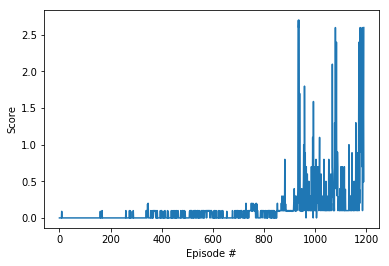

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()